# Bank's Credit Card Service Churn Prediction

# 1. Business problem
- A <b>manager</b> at the bank</b> is disturbed</b> with more and more <b>customers leaving their credit card services</b>. They would really appreciate if one could <b>predict for them how likely is a customer to churn</b> so they can proactively go to the customers to <b>provide them better services and turn customers' decisions in the opposite direction.</b>
- <b>1.1 What is the context?</b>
    - When a <b>bank acquires a customer</b> for its credit card service, three essential <b>Key Performance Indicators (KPIs)</b> to consider include:
    
    - <b>1. Customer Acquisition Cost (CAC):</b> This measures the expenses associated with acquiring each credit card customer, encompassing marketing, sales, and related costs. Lower CAC reflects efficient customer acquisition.<br>
    - <b>2. Customer Lifetime Value (CLV):</b> CLV estimates the total revenue the bank can expect to generate from a credit card customer over their relationship. A higher CLV indicates that the customer's value surpasses the acquisition cost, ensuring long-term profitability.<br>
    - <b>3. Churn Rate:</b> Churn rate is typically expressed as a percentage and represents the number of credit card customers who have left during a specific period divided by the total number of customers at the beginning of that period.<br>
    - These <b>KPIs</b> help the bank assess the <b>effectiveness</b> of its strategies in acquiring credit card customers and gauge the potential long-term financial benefit of these acquisitions.
    - In order to <b>maximize profitability</b>, the bank aims to <b>minimize CAC and Churn while maximizing CLV.</b> 

- <b>Which are the project objectives?</b> 
    - <b>1. Identify the factors associated with customer churn.</b><br>
    - <b>2. Construct a model capable of accurately predicting the probability of a customer to churn.</b><br>
    - <b>3. Offer action plans for the bank to reduce credit card customer churn.</b><br>

- <b>Why the probability/score ordering approach?</b>
    - When deploying the model so that the bank can make predictions, the primary objective is to generate probability scores for each customer. This is typically more valuable for businesses when compared to making binary predictions (1/0), as it enables better decision-making and more effective customer retention strategies. 
    - For instance, predicting the probability of churn provides more actionable insights. Instead of simply determining whether a customer will churn or not, you gain an understanding of how likely it is to happen. This information enables the bank to allocate its efforts and resources more effectively. For example, it can concentrate its retention efforts on customers with a high probability of churning, ordering the customer from the most likely to churn to the less likely.

- <b>Which are the benefits?</b>
    - <b>1. Cost Savings</b><br>
    - <b>2. Improved Customer Retention</b><br>
    - <b>3. Enhanced Customer Experience</b><br>
    - <b>4. Targeted Marketing</b><br>
    - <b>5. Revenue Protection</b><br>

And as a result, the mentioned <b>business problem will be resolved.</b>

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Split the data.
from sklearn.model_selection import train_test_split

# Utils
# from ..src.utils.eda_utils import analysis_plot

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Visualization Settings
%matplotlib inline

mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

### Utils

In [3]:
def analysis_plots(data, features, histplot=True, barplot=False, mean=None, text_y=0.5,    
                   outliers=False, boxplot=False, boxplot_x=None, kde=False, hue=None, 
                   nominal=False, color='#023047', figsize=(24, 12)):
    # Get num_features and num_rows and iterating over the sublot dimensions.
    num_features = len(features)
    num_rows = num_features // 3 + (num_features % 3 > 0) 
    
    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)  

    for i, feature in enumerate(features):
        row = i // 3  
        col = i % 3  

        ax = axes[row, col] if num_rows > 1 else axes[col] 
        
        if barplot:
            if mean:
                data_grouped = data.groupby([feature])[[mean]].mean().reset_index()
                data_grouped[mean] = round(data_grouped[mean], 2)
                ax.barh(y=data_grouped[feature], width=data_grouped[mean], color=color)
                for index, value in enumerate(data_grouped[mean]):
                    # Adjust the text position based on the width of the bars
                    ax.text(value + text_y, index, f'{value:.1f}', va='center', fontsize=15)
            else:
                if hue:
                    data_grouped = data.groupby([feature])[[hue]].mean().reset_index().rename(columns={hue: 'pct'})
                    data_grouped['pct'] *= 100
                else:
                    data_grouped = data.groupby([feature])[[feature]].count().rename(columns={feature: 'count'}).reset_index()
                    data_grouped['pct'] = data_grouped['count'] / data_grouped['count'].sum() * 100
    
                ax.barh(y=data_grouped[feature], width=data_grouped['pct'], color=color)
                
                if pd.api.types.is_numeric_dtype(data_grouped[feature]):
                    ax.invert_yaxis()
                    
                for index, value in enumerate(data_grouped['pct']):
                    # Adjust the text position based on the width of the bars
                    ax.text(value + text_y, index, f'{value:.1f}%', va='center', fontsize=15)
            
            ax.set_yticks(ticks=range(data_grouped[feature].nunique()), labels=data_grouped[feature].tolist(), fontsize=15)
            ax.get_xaxis().set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
    
        elif outliers:
            # Plot univariate boxplot.
            sns.boxplot(data=data, x=feature, ax=ax, color=color)
        
        elif boxplot:
            # Plot multivariate boxplot.
            sns.boxplot(data=data, x=boxplot_x, y=feature, showfliers=outliers, ax=ax)

        else:
            # Plot histplot.
            sns.histplot(data=data, x=feature, kde=kde, ax=ax, color=color, stat='proportion', hue=hue)

        ax.set_title(feature)  
        ax.set_xlabel('')  
    
    # Remove unused axes.
    if num_features < len(axes.flat):
        for j in range(num_features, len(axes.flat)):
            fig.delaxes(axes.flat[j])

    plt.tight_layout()

In [4]:
def check_outliers(data, features):
    
    outlier_counts = {}
    outlier_indexes = {}
    total_outliers = 0
    
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        feature_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_indexes[feature] = feature_outliers.index.tolist()
        outlier_count = len(feature_outliers)
        outlier_counts[feature] = outlier_count
        total_outliers += outlier_count
    
    print(f'There are {total_outliers} outliers in the dataset.')
    print()
    print(f'Number (percentage) of outliers per feature: ')
    print()
    for feature, count in outlier_counts.items():
        print(f'{feature}: {count} ({round(count/len(data)*100, 2)})%')

    return outlier_indexes, outlier_counts, total_outliers

# 2. Understanding the data
- The dataset was collected from kaggle: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?sort=votes
- The dataset origin is from this site: https://leaps.analyttica.com/home
- It contains credit card customers data, with demographic, financial and product information. It is already labeled, with churners identified as 1 and non-churners identified as 0 in the attrition flag variable.
- I will initially drop two variables because I don't have access to what they mean, and they seem to be results of a Naive Bayes machine learning model.

In [5]:
data_path = '../data/input/BankChurners.csv'
df = pd.read_csv(data_path)

# Features that must be dropped.
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], inplace=True)

In [6]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [8]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 10127 rows and 21 columns.


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


Some insights:
1. The average age is approximately 46 years. Half the customers are from 41 to 52 years old, indicating an older profile.
2. On average, customers held approximately 4 products of the bank.
2. 75% of the customers spent at least 2 months inactive in the last 12 months. This is a bad indicator. The bank must plan strategies to improve its clients consumption.
3. 75% of the customers contacted the bank at least 2 times in the last 12 months. This is also bad, something in the credit card product is leading customers to contact the company, probably unsatisfied.
2. The average credit limit is 8,632. Moreover, it seems to be skewed to the right (mean is greater than median, minimum credit limit is 1,438, while maximum is 34,516).
4. The average utilization ratio is about 28%. This is a low value. Moreover, half the customers present a utilization ratio up to 17.6%. The bank must pay attention to it and try to increase the utilization of its credit card service.
5. On average, customers made approximately 65 transactions in the last 12 months. This indicates that customers made about 5.4 transactions per month in a year, which is very low.
6. Moreover, observing the minimum and maximum values, seems there are no inconsistent values.

Looking at missing ad duplicated values.

In [10]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

No Missing Values found in data

- Drop `CLIENTNUM` variable for analysis since it has all unique values. No insights provided
- Rename Columns in standard format for easier data manipulation.
- Express `Gender` and `Attrition_Flag` as binary variables for easier representation.

In [12]:
df.drop(columns=['CLIENTNUM'], inplace=True)

df.columns = [x.lower() for x in df.columns]

df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['attrition_flag'] = df['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)

# 3. Split the data into train and test sets
- Split Data into Train and Test sets.
- Perform EDA on training set to avoid data leakage, and evaluate model with unseen data
- Perform Startified Split for Train and Test sets to maintain same percentage of target class
This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more existing customers than attrited ones.

In [13]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (8101, 19).
Train target dataset shape: (8101,).
Test predictor dataset shape: (2026, 19).
Test target dataset shape: (2026,).


In [15]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Test target proportion: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


# 4. Exploratory data analysis

In [16]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn_flag
2856,36,0,0,Unknown,Married,Less than $40K,Blue,24,4,3,2,2570.0,2230,340.0,0.686,1755,42,0.448,0.868,0
6515,44,1,3,High School,Single,$60K - $80K,Silver,36,5,2,3,25276.0,0,25276.0,0.849,2282,38,0.583,0.000,1
7141,46,1,2,High School,Married,$80K - $120K,Blue,30,6,3,1,11670.0,915,10755.0,0.892,4277,89,0.854,0.078,0
632,36,0,2,Graduate,Married,Less than $40K,Blue,24,3,1,3,3124.0,1593,1531.0,0.869,1652,41,0.367,0.510,0
3496,50,1,1,Graduate,Single,$120K +,Blue,40,4,2,3,34516.0,1185,33331.0,0.725,3874,72,0.714,0.034,0


In [17]:
numerical_features = X_train.select_dtypes('number').columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()
target = 'churn_flag'

print(f'There are {len(numerical_features)} numerical features. They are: ')
print(numerical_features)
print(f'\nThere are {len(categorical_features)} categorical features. They are: ')
print(categorical_features)
print(f'\nThe target feature is: {target}.')

There are 15 numerical features. They are: 
['customer_age', 'gender', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio']

There are 4 categorical features. They are: 
['education_level', 'marital_status', 'income_category', 'card_category']

The target feature is: churn_flag.


Check for Cardinality of Categorical Features before choosing encoding techniques

In [18]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {train[feature].nunique()} unique values. They are: ')
    print(train[feature].value_counts(normalize=True))
    print()

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, dtype: float64

card_category
----------------------------------------
There are 4 unique values. They are: 
card_category
Blue        0.933095
Silver     

- `education_level`, `income_category` and `card_category` present ordinal relationships. Thus, OrdinalEncoder might be a good choice for encoding them.
- Except `card_category`, all the categoric attributes have an 'unknown' category. Need to investigate the distribution of churn inside this category and decide how to deal with it further. If 'unknown' presents discrimination between churners and non-churners, it will be a good practice to leave it as another category of the variables. Imputing or removing them would introduce bias and information loss, since the churn pattern does not occur at random inside this group and it would help the model to distinguish between attrited and non-attrited customers.

## Univariate analysis

### Target distribution

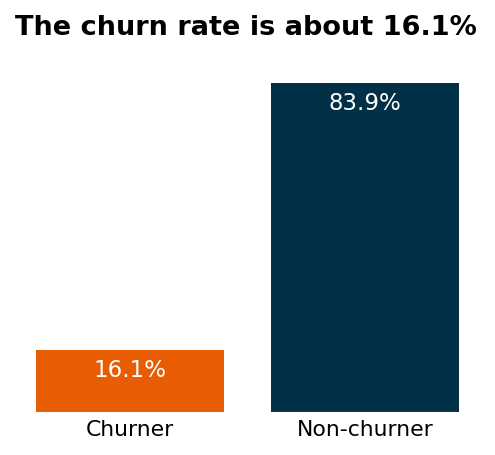

In [19]:
# Group the data by churn flag.
churn_grp = train.groupby(['churn_flag'])[['churn_flag']].count().rename(columns={'churn_flag': 'count'}).reset_index()
churn_grp['pct'] = (churn_grp['count'] / churn_grp['count'].sum()) * 100
churn_grp = churn_grp.sort_values(by=['pct'])

# Define the plot.
fig, ax = plt.subplots(figsize=(4, 3))
        
# Plot the barplot.
bars = ax.bar(x=churn_grp['churn_flag'], height=churn_grp['pct'], color=['#e85d04', '#023047'])
        
# Customize the plot.
ax.set_title('The churn rate is about 16.1%', fontweight='bold', fontsize=13, pad=15, loc='left')
ax.set_xlabel('')
ax.set_xticks(ticks=range(2), labels=['Non-churner', 'Churner'], fontsize=10.5)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.invert_xaxis()
        
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.1f}%'.format(height), 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -10),  
                textcoords="offset points",
                ha='center', va='center',
                fontsize=11, color='white')

The target is imbalanced. 16.1% of the customers are churners. Thus, We need to adopt some strategies in order to deal with this. They are:

- Stratified hold-out and k-fold cross validation to maintain the target proportion on test and validation sets, even for hyperparameter tuning.
- Define different class weights for majority and minority class instances. The idea is to define higher weights to minority class, such that the model will be penalized when mistakenly classifying a churner customer. These weights are defined on the model specific hyperparameter for it.
- Take a look at precision-recall trade-off if necessary. The main objective here is to predict churn probabilities, not a binary prediction. This will enable the bank to make better informed decisions. Instead of simply assessing if a client will attrit or not, it can check how likely he is to skip the service.

### Numerical features distributions

In [20]:
numplots_features = ['customer_age', 
                     'months_on_book', 
                     'credit_limit', 
                     'total_revolving_bal', 
                     'avg_open_to_buy', 
                     'total_amt_chng_q4_q1', 
                     'total_trans_amt', 
                     'total_trans_ct', 
                     'total_ct_chng_q4_q1', 
                     'avg_utilization_ratio',
                     'total_relationship_count']

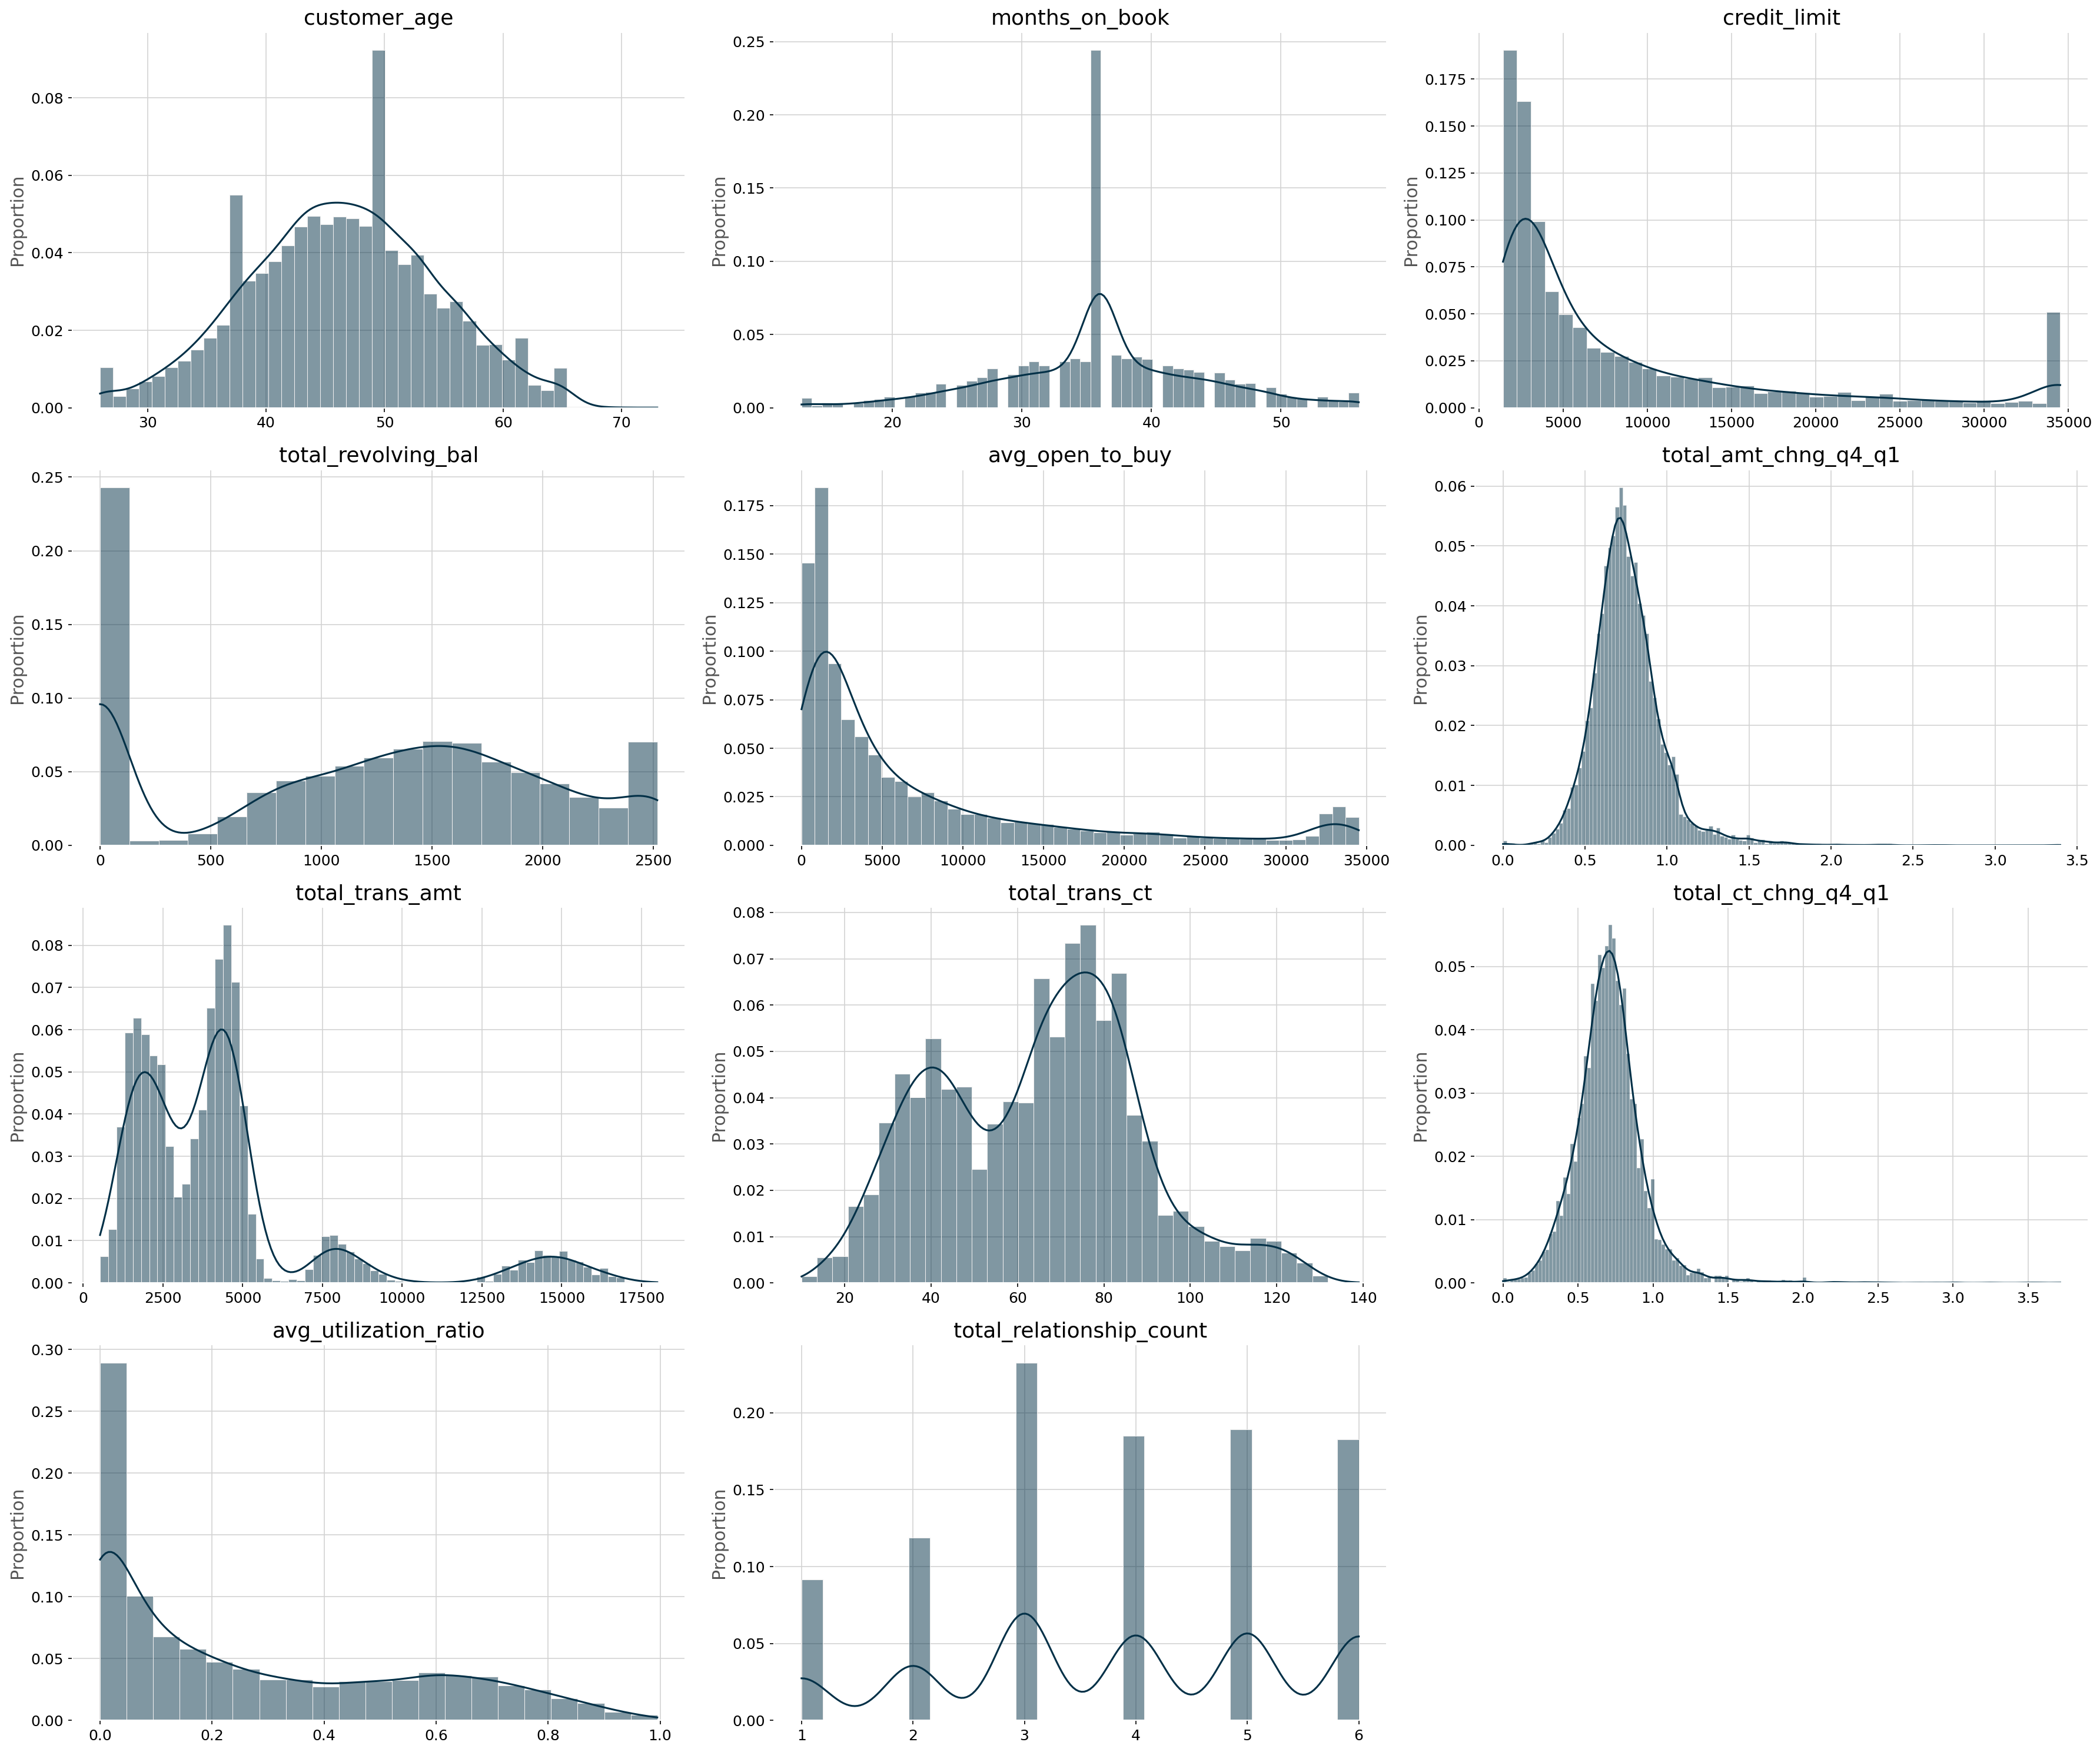

In [21]:
analysis_plots(data=train, features=numplots_features, kde=True, figsize=(24, 20))

Insights:
- Most of the customers are between 40 and 50 years old.
- A large part of the customers spent 36 months consuming the bank's credit card services.
- The credit limit is right-skewed. This means that the majority of customers have low credit limits, while there are relatively few customers with high credit limits. However, it is possible to see that a significant portion of them, about 5%, has a high credit limit, around 35,000. Moreover, both avg_open_to_buy and avg_utilization_ratio are also positively skewed.
- The bank must be alert to the distribution of the average utilization ratio. Being right-skewed means that most customers have a low utilization of the service. Particularly, a large part of them, about 25%, present zero utilization ratio. Therefore, the company must plan strategies to increase utilization and, consequently, revenue.
- A large portion of the customers, also about 25%, have a zero total revolving balance. Lower total revolving balances (specially zero) might indicate a significant likelihood of churn. Considering average utilization ratio and total revolving balance present the same proportion of zero records, these variables might be correlated. I will investigate this further in the analysis.
- Total transaction count and amount distributions seem to have two peaks. There must be a distinction in these distributions with respect to churn flag, which I will investigate further in the analysis. Moreover, a large part of the customers made around 80 or 40 transactions in the last 12 months. Transaction amounts about 5,000 and 2,500 were common.
- About 80% of the customers held at least 3 products of the bank.

### Outliers

In [22]:
outlier_indexes, outlier_counts, total_outliers = check_outliers(data=train, features=numplots_features)

There are 3344 outliers in the dataset.

Number (percentage) of outliers per feature: 

customer_age: 2 (0.02)%
months_on_book: 450 (5.55)%
credit_limit: 784 (9.68)%
total_revolving_bal: 0 (0.0)%
avg_open_to_buy: 775 (9.57)%
total_amt_chng_q4_q1: 311 (3.84)%
total_trans_amt: 704 (8.69)%
total_trans_ct: 1 (0.01)%
total_ct_chng_q4_q1: 317 (3.91)%
avg_utilization_ratio: 0 (0.0)%
total_relationship_count: 0 (0.0)%


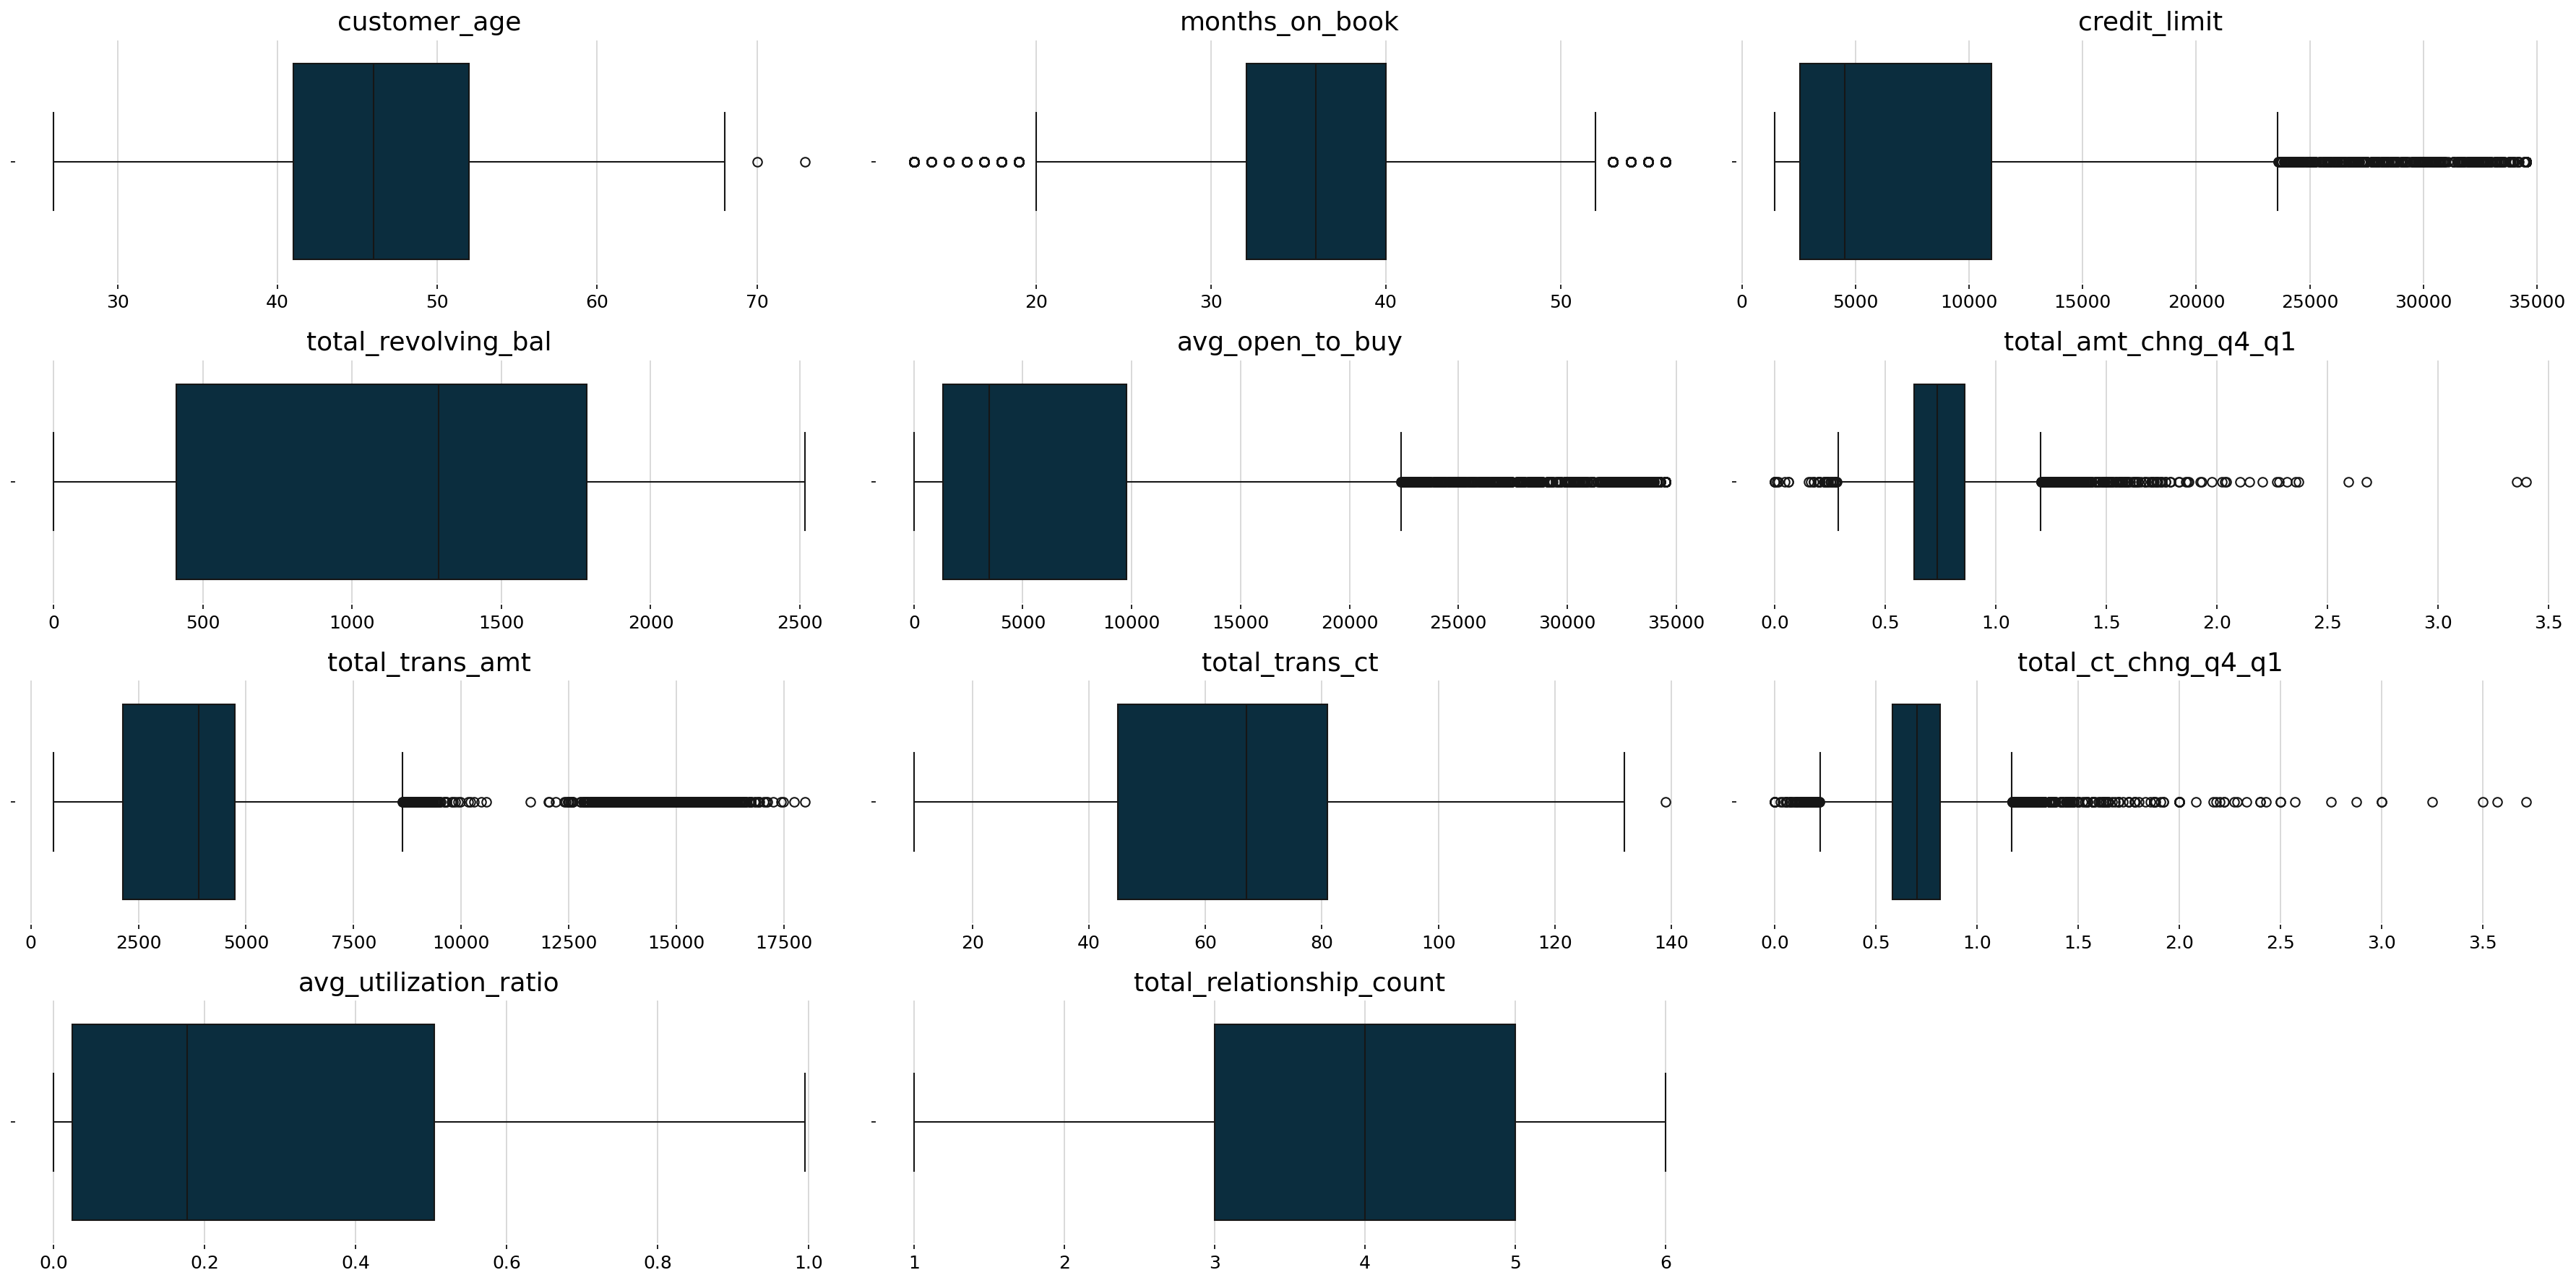

In [23]:
analysis_plots(data=train, features=numplots_features, outliers=True)

### Categorical features distributions

In [24]:
barplot_discrete_features = ['gender', 
                             'dependent_count', 
                             'months_inactive_12_mon', 
                             'contacts_count_12_mon']
barplot_features = barplot_discrete_features + categorical_features

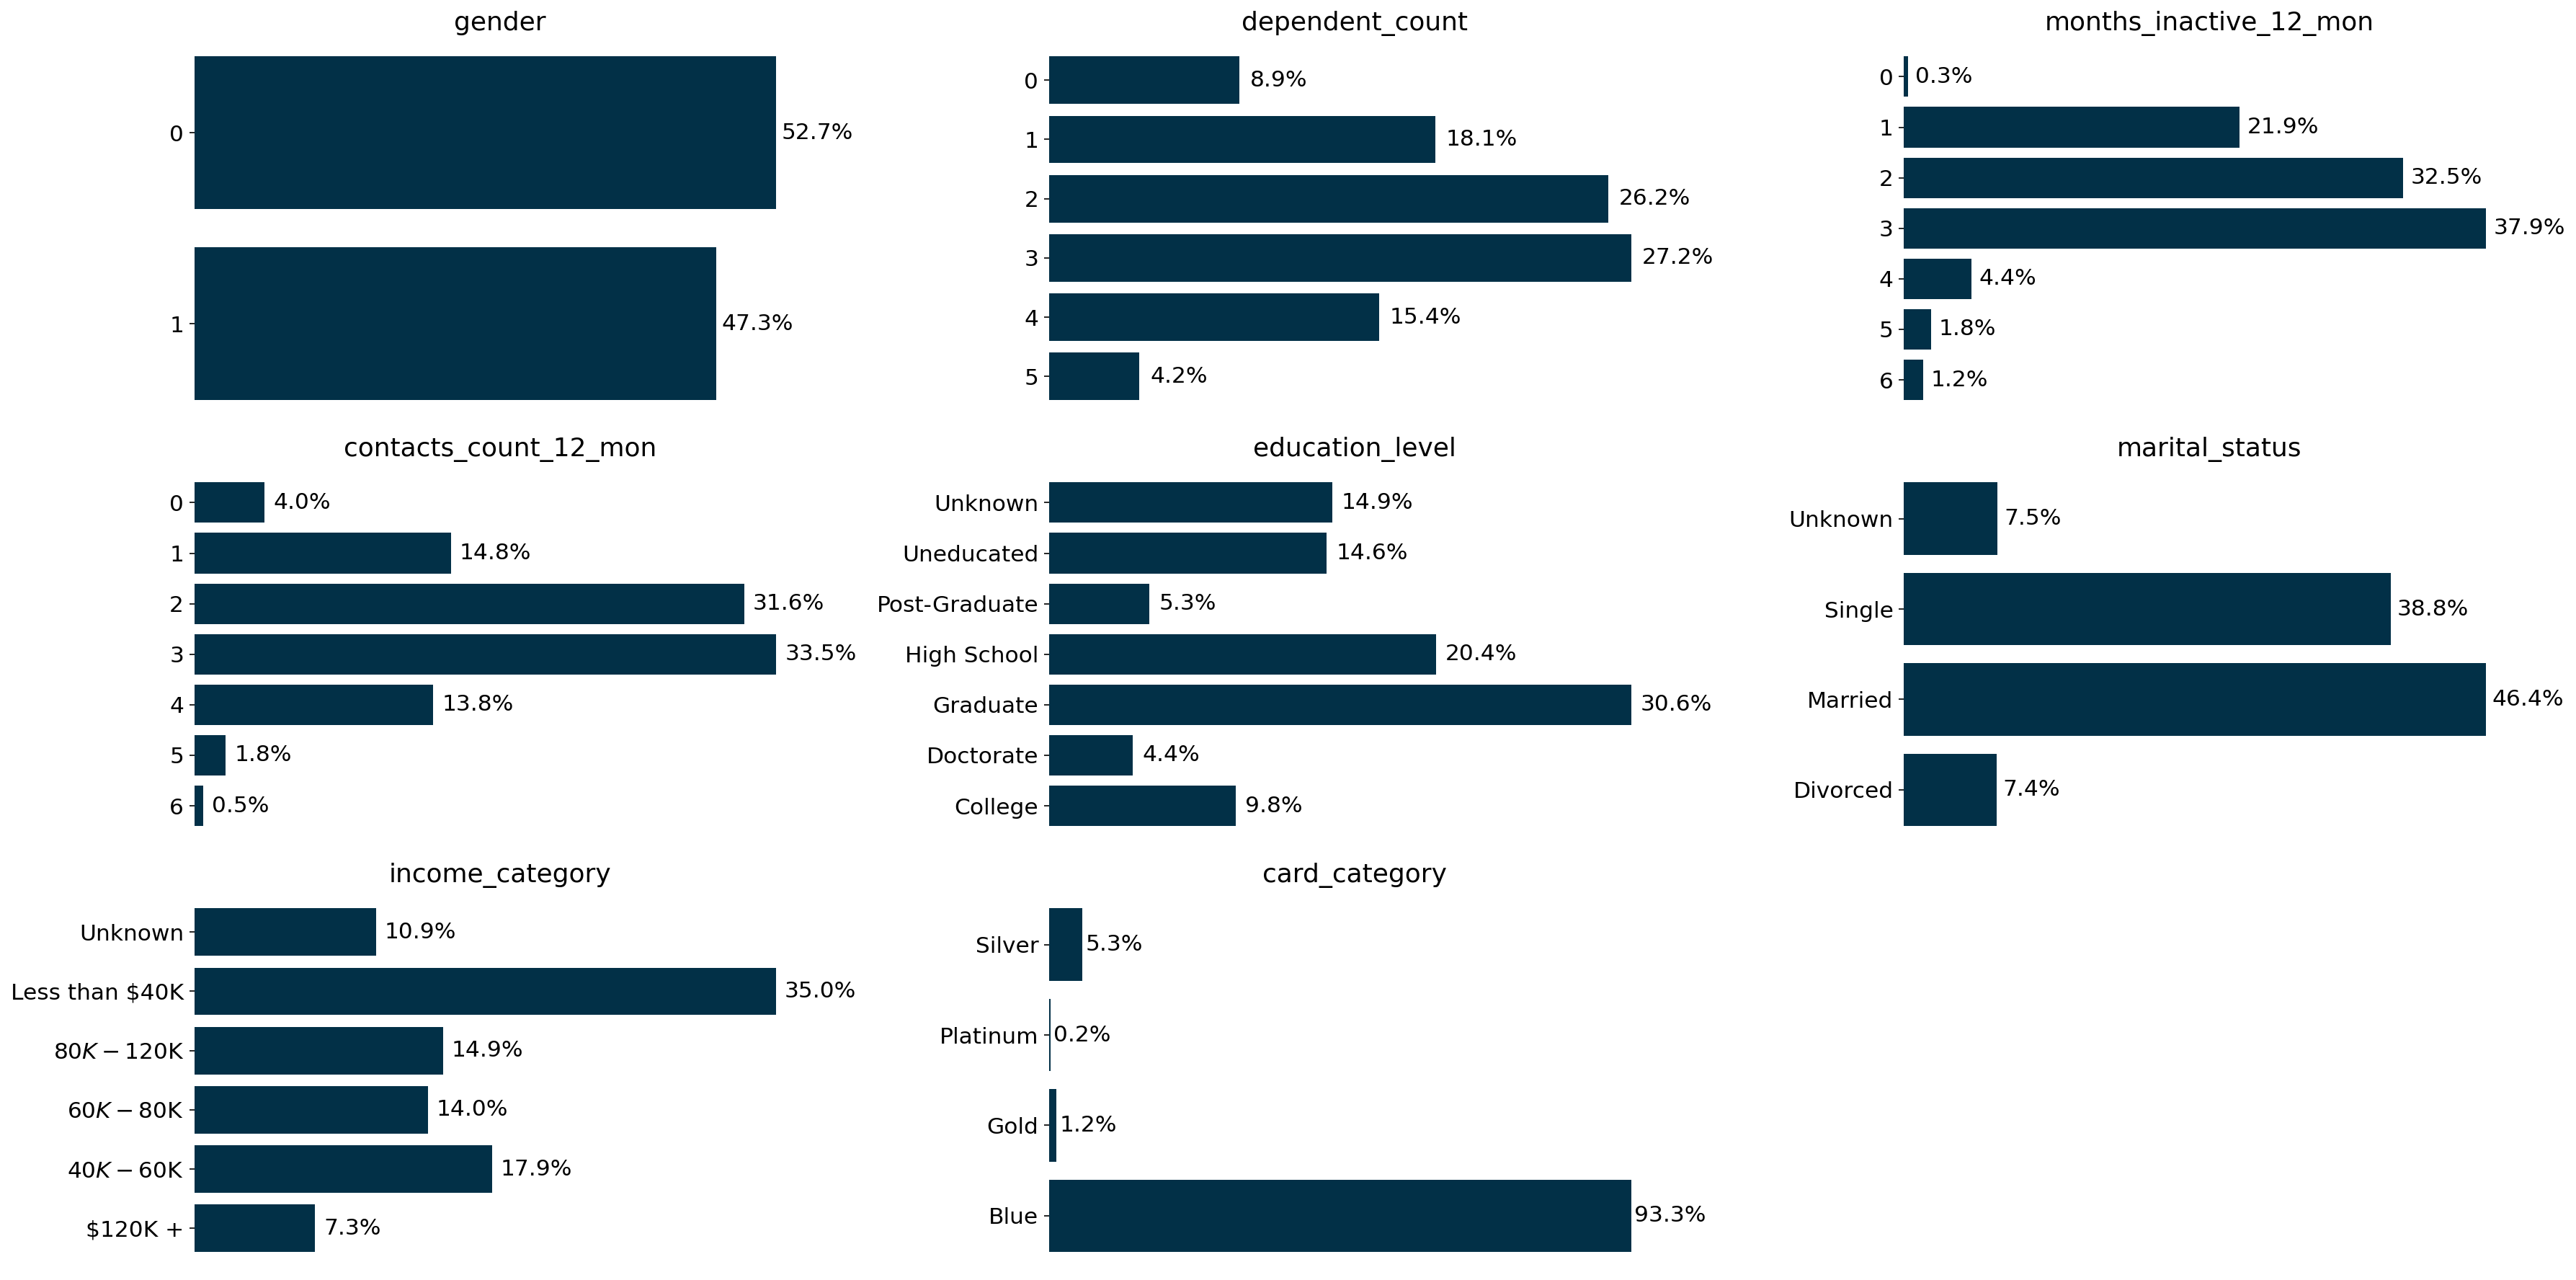

In [25]:
analysis_plots(data=train, features=barplot_features, barplot=True, figsize=(24, 12))

Insights:
- Almost 53% of the customers are female.
- More than 50% of the customers have 2 or 3 dependents.
- 90% of the customers were inactive from 1 to 3 months in the last year. The bank must plan strategies not only to increase the utilization ratio, but also to avoid customer inactivity.
- Most of the customers (approximately 65% of them) contacted the bank 2 or 3 times in the last 12 months. 
- Most of the customers are married or single, graduate, make less than $40K and hold a blue credit card.
- There are some categories with extremely low proportions of observations, like 0 months inactive and 6 contacts count in the last 12 months. Moreover, card category is highly imbalanced, with almost 99% of the customers having blue or silver types. Particularly, blue corresponds to 93.3% of the observations. This will be taken into account in the modeling step. Leaving categories with extremely low proportions of observations can lead to overfitting and card category may not have discriminatory power.

## Bivariate and multivariate analysis

### Correlation matrix

In [26]:
corr_matrix = train.corr(numeric_only=True)

In [27]:
corr_matrix['churn_flag'].sort_values(ascending=False)

churn_flag                  1.000000
contacts_count_12_mon       0.205486
months_inactive_12_mon      0.157937
dependent_count             0.030940
customer_age                0.017256
months_on_book              0.008124
avg_open_to_buy             0.000161
credit_limit               -0.023976
gender                     -0.042009
total_amt_chng_q4_q1       -0.129157
total_relationship_count   -0.157092
total_trans_amt            -0.173479
avg_utilization_ratio      -0.188519
total_revolving_bal        -0.267587
total_ct_chng_q4_q1        -0.286473
total_trans_ct             -0.372500
Name: churn_flag, dtype: float64

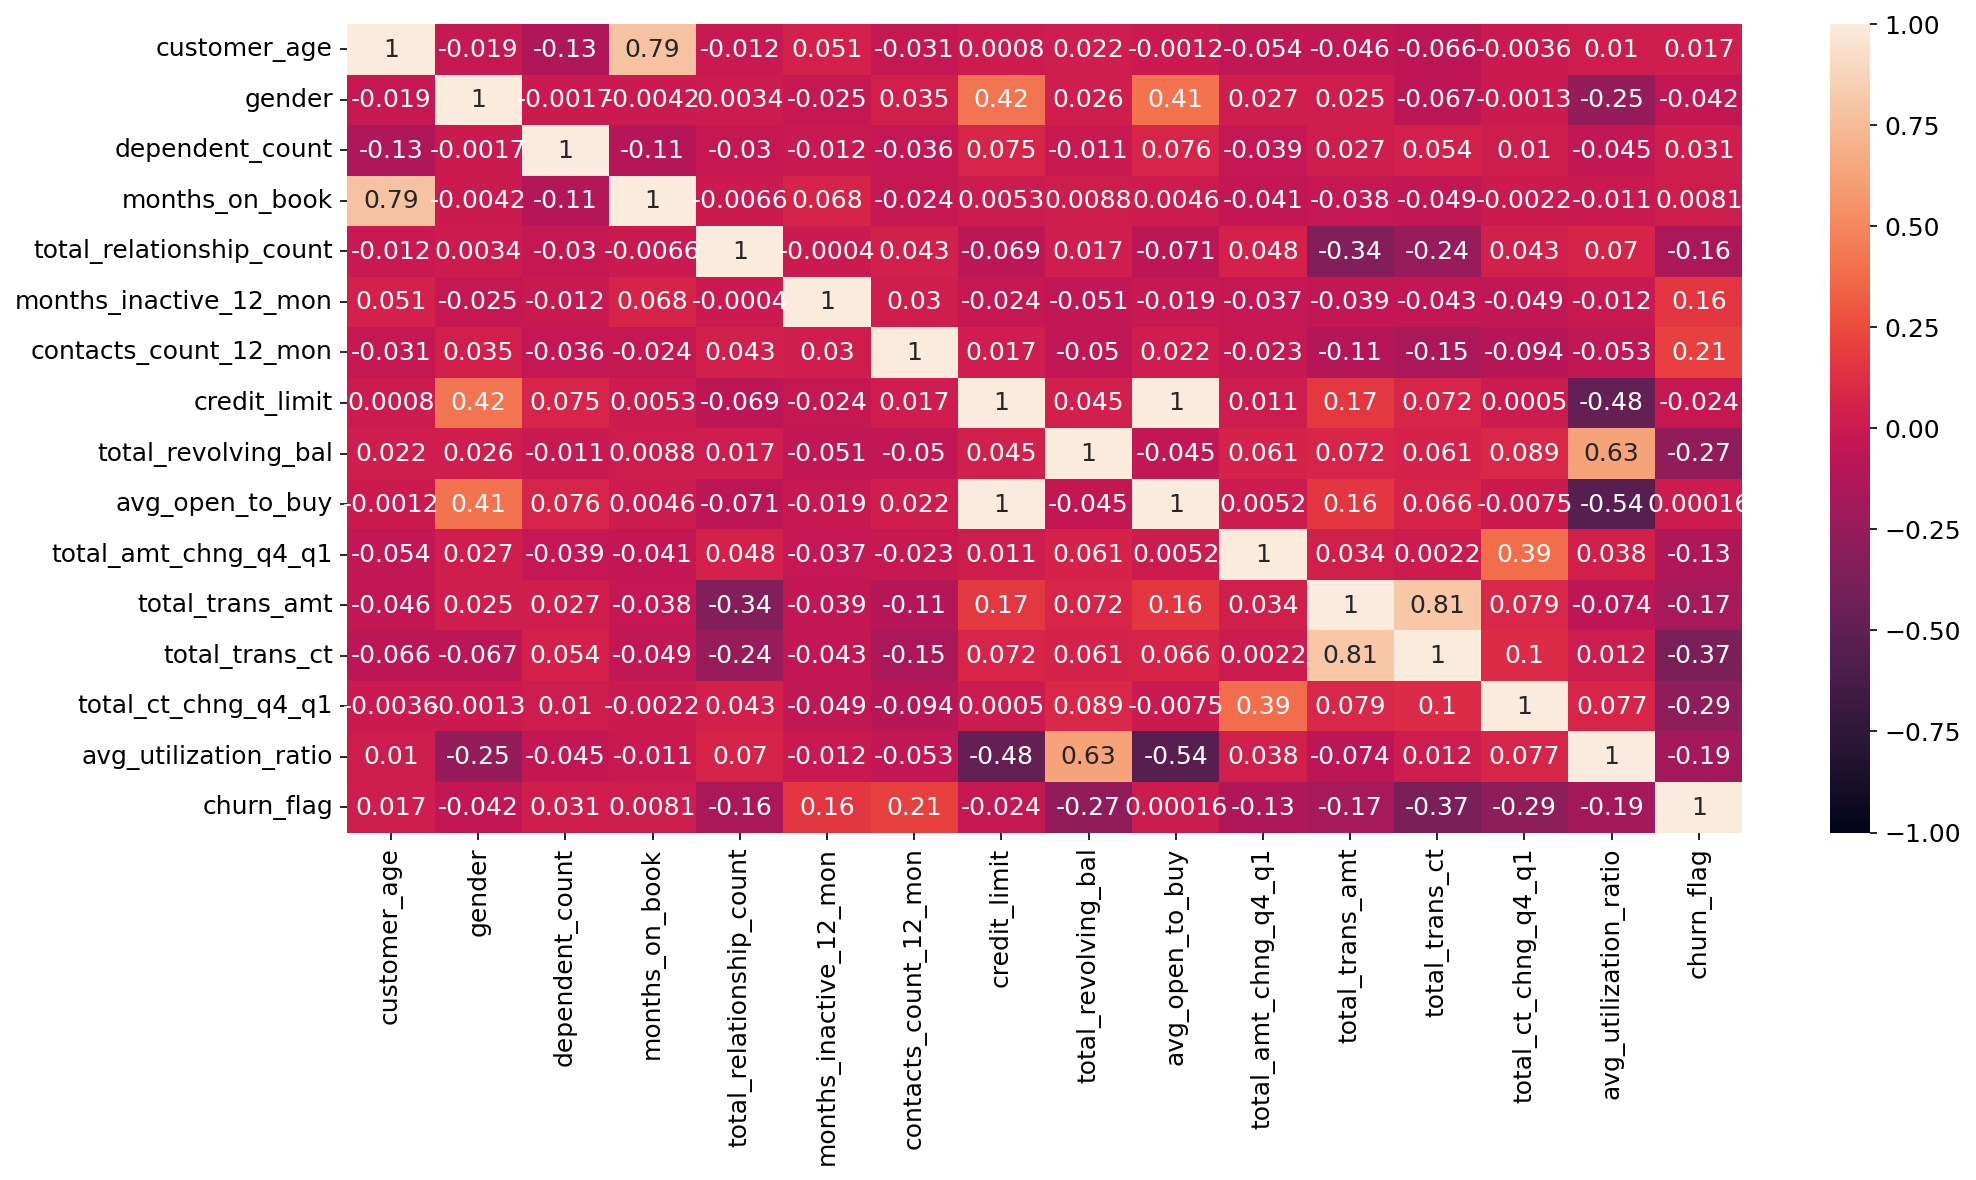

In [28]:
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
plt.show()

Insights:
- `Total transaction count`, `total revolving balance` and `total count change` have a moderate negative correlation with the target. This makes total sense. The less transactions a customer makes, the more he is likely to churn. Also, customers with lower revolving balances and less variation in their transaction counts are prone to churn due to inactivity.
- `Customer age` and `months on book` are strongly positively correlated. The older a customer is, the more time he spends consuming the bank's credit card services and vice-versa. Thus, the company must focus its efforts on retaining the old loyal customers and increase the tenure of younger ones.
- `Credit limit` and `average utilization ratio` are moderately negatively correlated. The higher the customer's credit limit, the lower the average utilization ratio.
- `Total revolving balance` and `average utilization ratio` are strongly positively correlated. This makes sense. As a customer uses more his credit card, he will have to pay higher revolving balances.
- Curiously, `gender` has a moderate positive correlation with `credit limit`. This may indicate that male customers tend to have higher credit limits than female ones.
- Some features that are naturally related are highly correlated, as expected. This is the case for `total transaction amount` and `total transaction count`. When building linear models, we have to worry with multicolinearity issues, which occurs when two or more independent variables are highly correlated. Although it is diagnosed with variance inflation factor, observing pearson correlation between pairs can indicate us this issue. It is the case here. However, once I will focus on predictive power, using more robust algorithms like LightGBM, I will not worry with this now.
- Curiously, average open to buy and credit limit are perfectly positively correlated. This means these two variables have a strong and consistent linear relationship in the same direction. This makes sense since open to buy means the amount left in your credit card to use and limit means the used amount which hasn't been paid off yet. Because they present this perfect correlation, one of them becomes redundant. Thus, I will drop avg_open_to_buy in the modeling step because credit_limit is more informative.

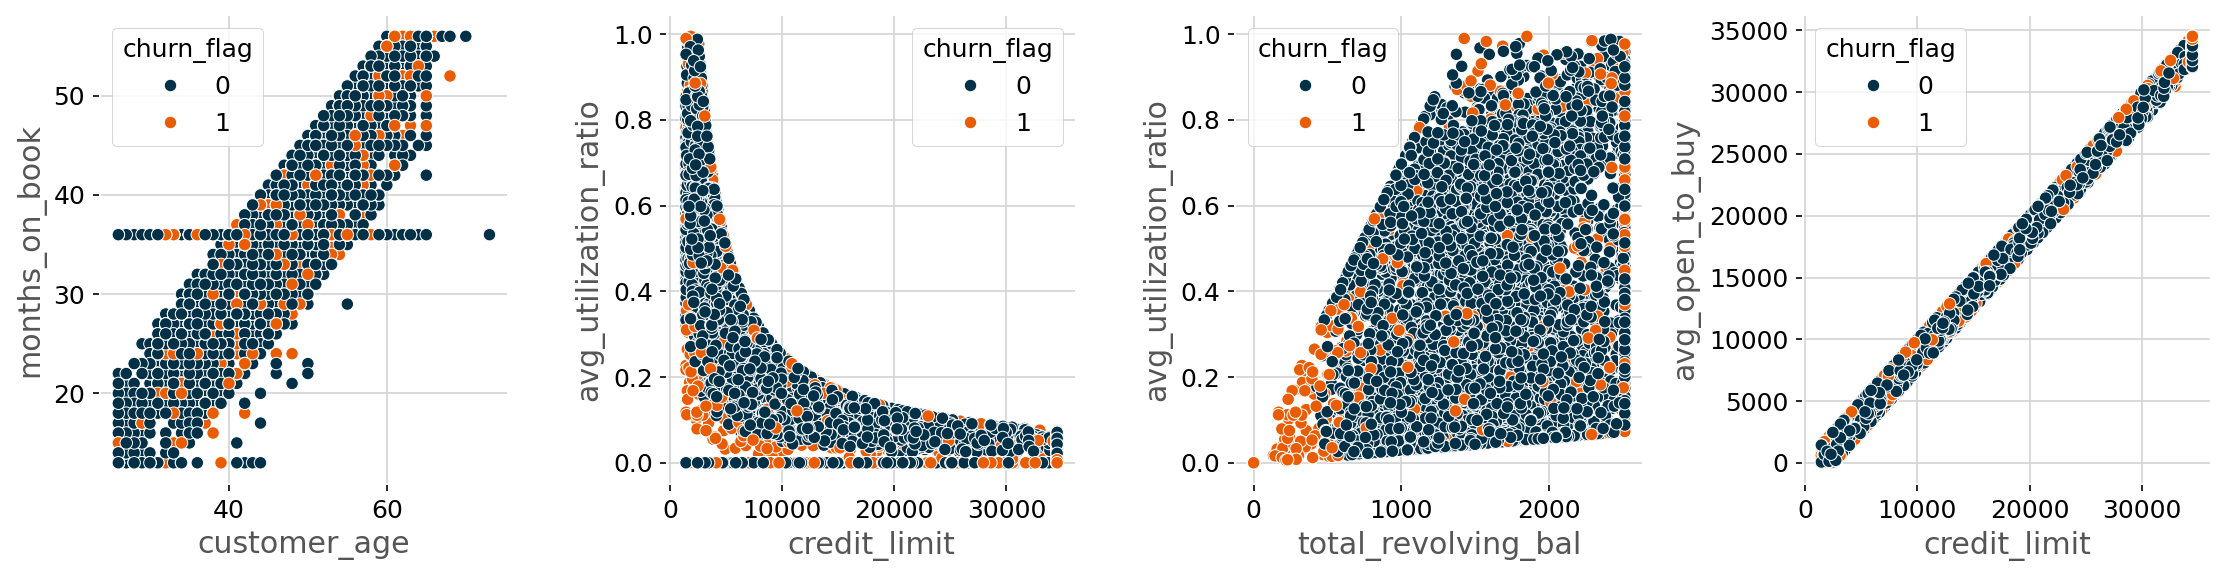

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.scatterplot(data=train, x='customer_age', y='months_on_book', hue='churn_flag', ax=axes[0])
sns.scatterplot(data=train, x='credit_limit', y='avg_utilization_ratio',  hue='churn_flag', ax=axes[1])
sns.scatterplot(data=train, x='total_revolving_bal', y='avg_utilization_ratio',  hue='churn_flag', ax=axes[2])
sns.scatterplot(data=train, x='credit_limit', y='avg_open_to_buy',  hue='churn_flag', ax=axes[3])
plt.tight_layout()
plt.show()

`Credit limit` and `average utilization ratio` present an exponential decreasing relationship! 
This indicates that, as credit limit increases, the average utilization ratio decreases at an exponential rate. Thus, customers with higher credit limits use their credit cards less.

### Numerical features distributions by churn flag

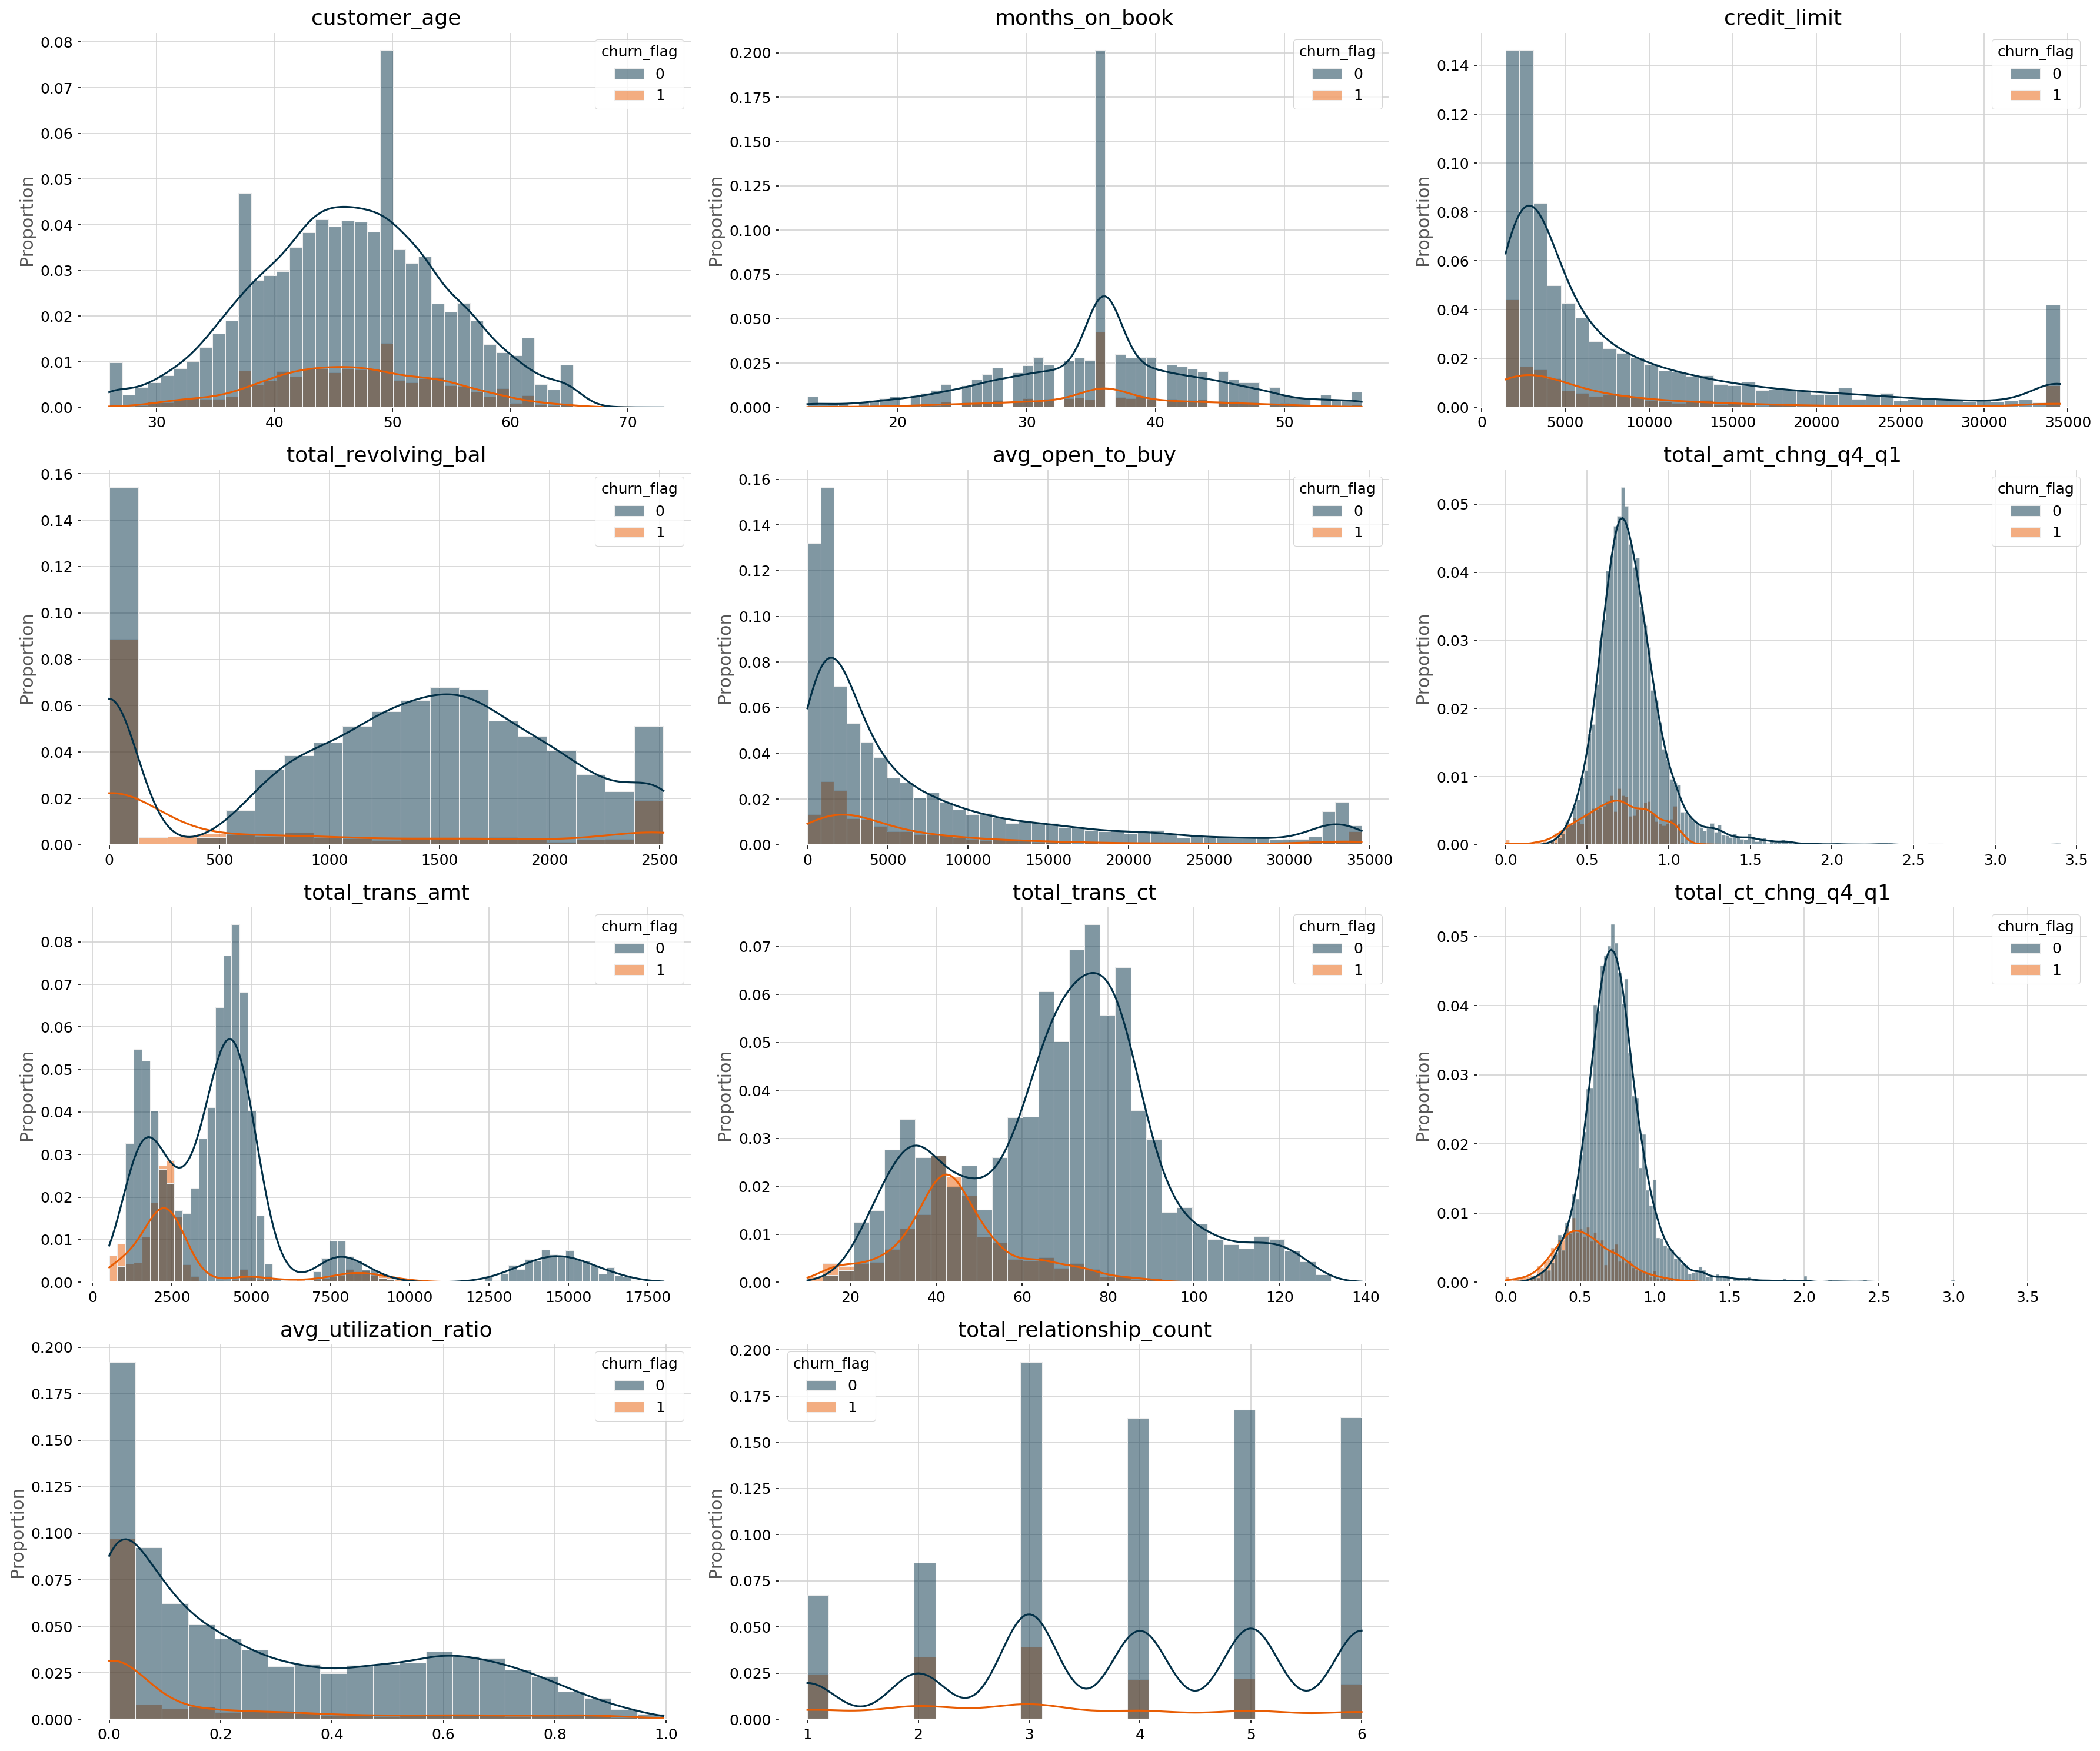

In [30]:
analysis_plots(data=train, features=numplots_features, histplot=True, kde=True, hue=target, figsize=(24, 20))

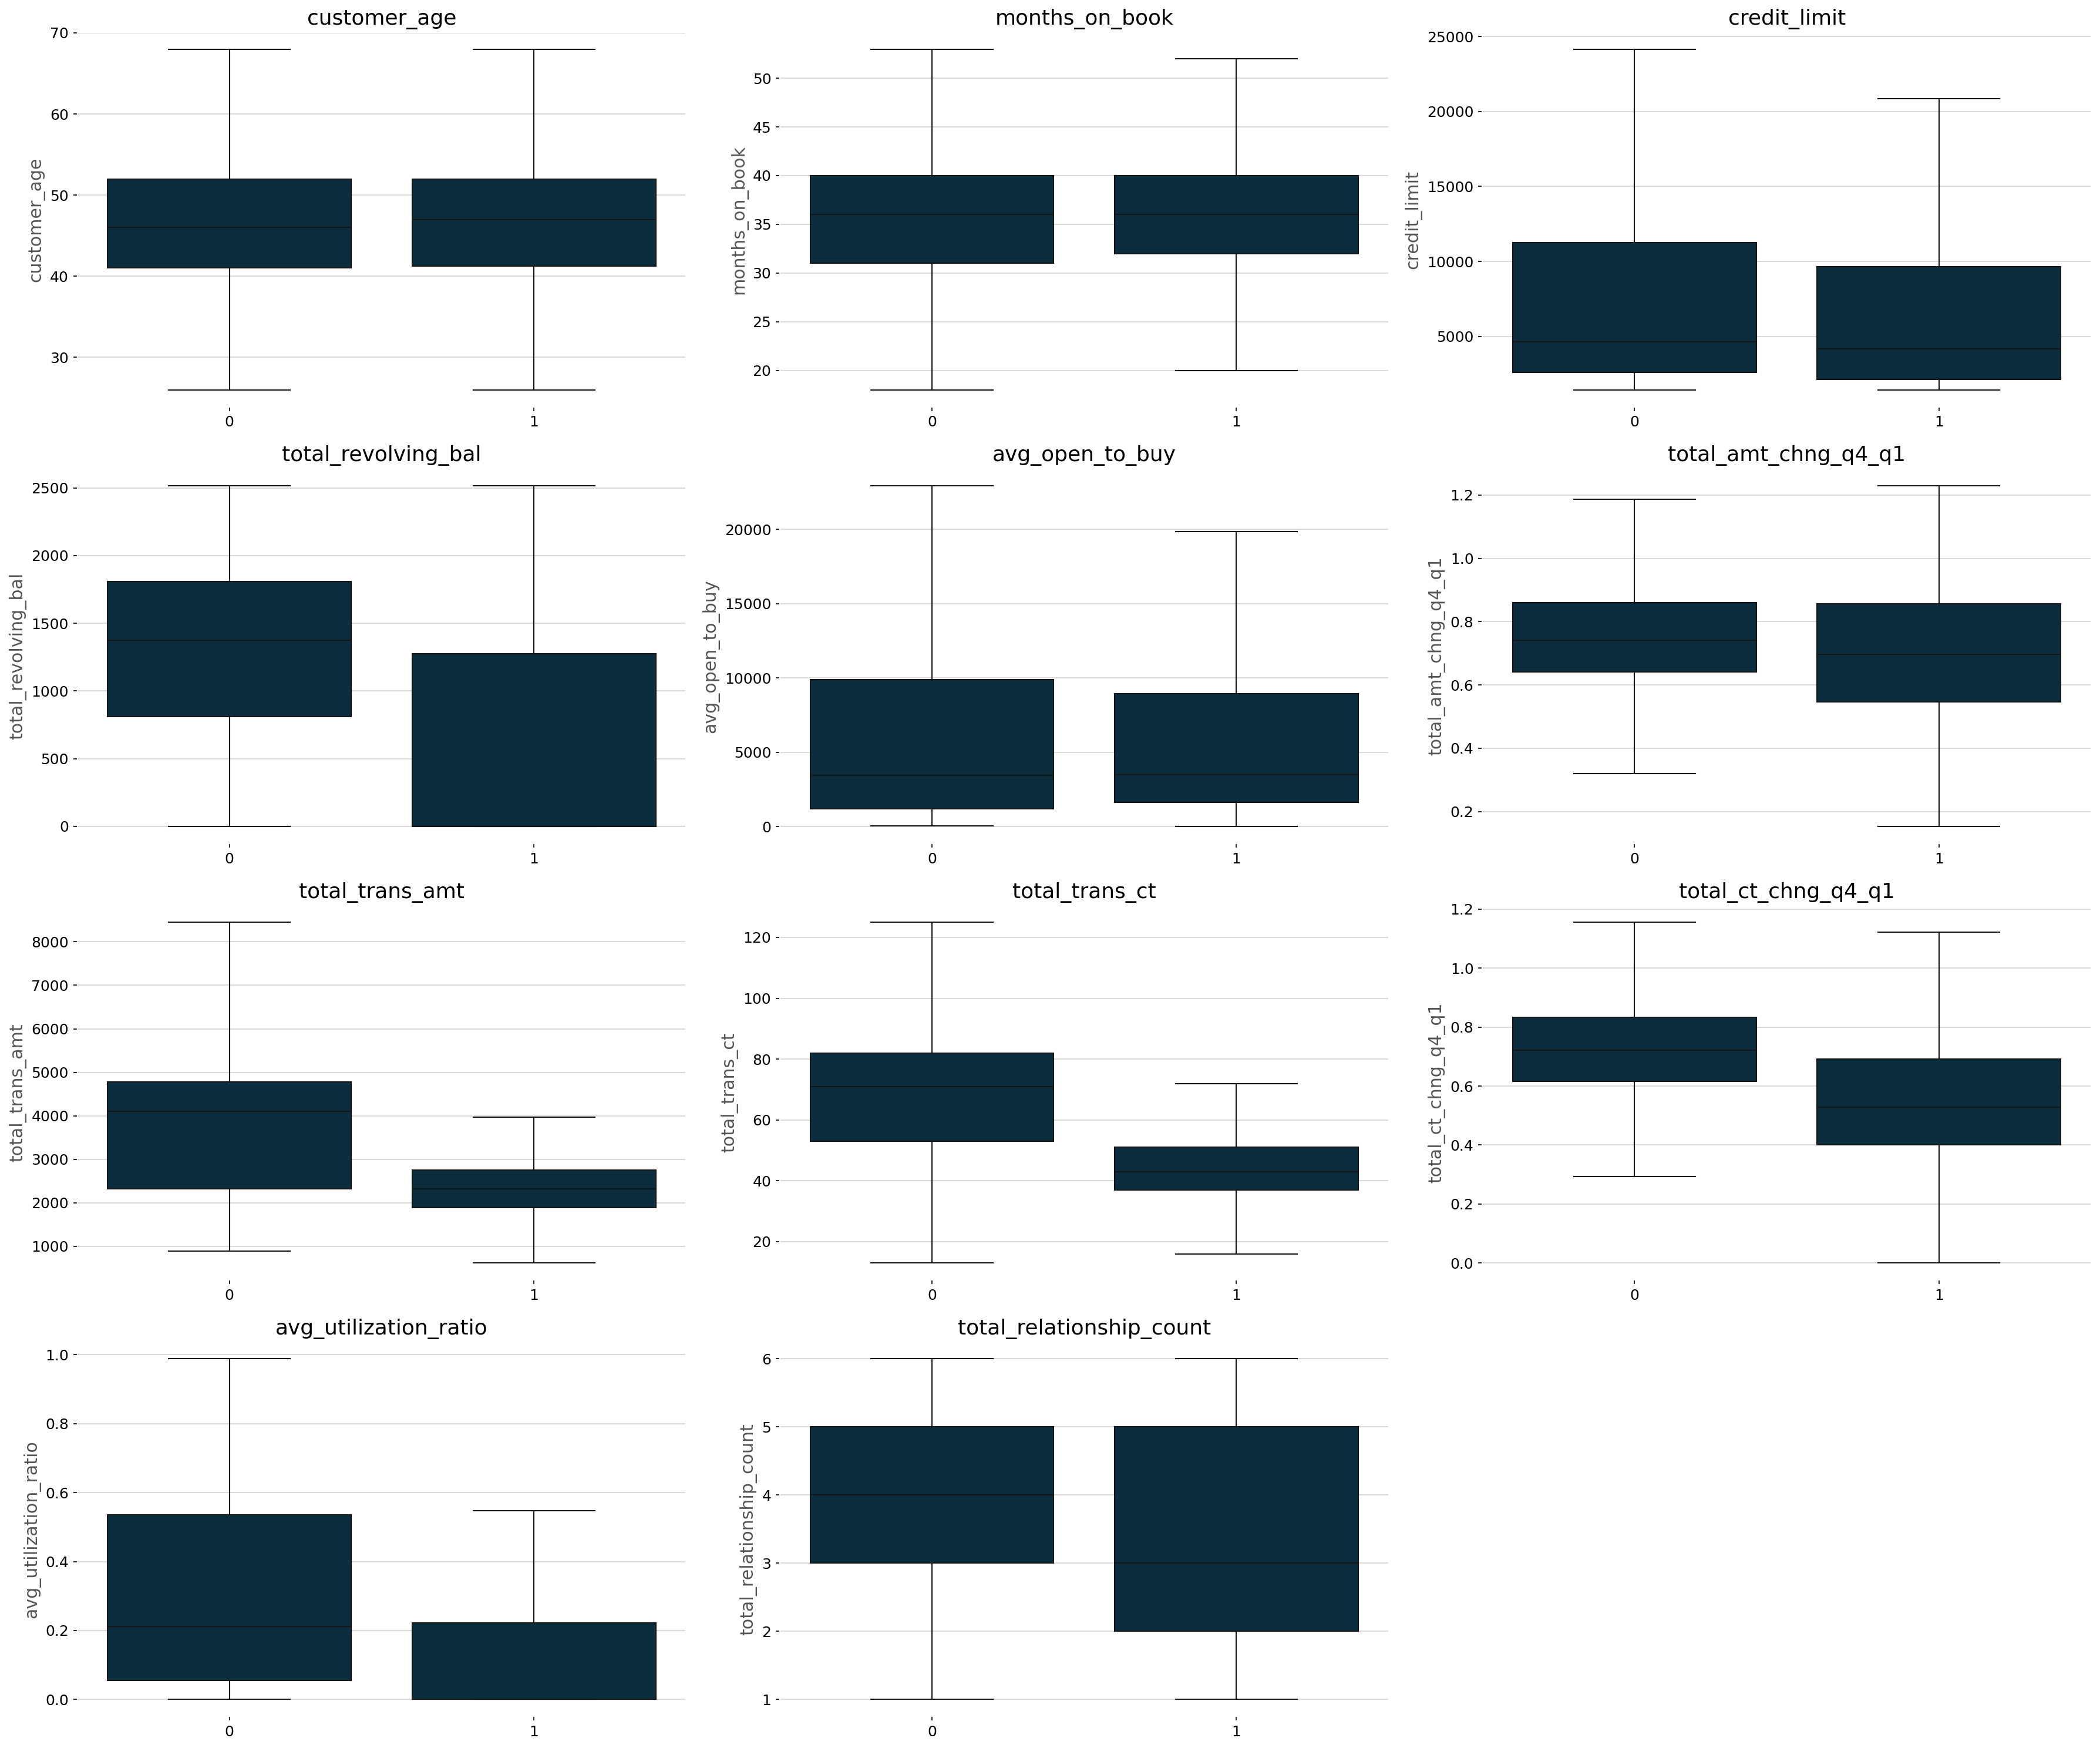

In [31]:
analysis_plots(data=train, features=numplots_features, boxplot=True, boxplot_x=target, figsize=(24, 20))

Insights:
- Customers who churn tend to have fewer products from the bank. Attrited customers generally have between 1 and 3 products
- Customers who churn tend to have slightly lower credit limits.
- Customers who churn tend to have lower revolving balances, which makes sense since churners tend to use their credit cards less. Especially, a large part of them present a zero revolving balance.
- Customers who churn tend to have lower transaction amounts, which makes total sense. When a client is about to discontinue the service, he will make fewer transactions, resulting in lower amounts in a period.
- Customers who churn tend have lower transaction counts, which makes total sense. When a client is about to discontinue the service, he will make fewer transactions.
- Customers who churn tend to have lower changes in their transaction counts, which makes sense since making fewer transactions will reduce the variation in counts.
- As expected, customers who churn tend to have lower average utilization ratio. Particularly, many of them tend to have a zero utilization ratio.
- An important observation is that a good pratice would be to discretize these continuous features to better analyze their distributions per churners and non-churners. However, with the graphs above we can clearly see a discrimination, and, as I intend to focus on predictive power, building more robust models such as LightGBM, in terms of preprocessing, feature discretization would increase dimensionality and probably be harmful.

### Categorical features distributions by churn rate

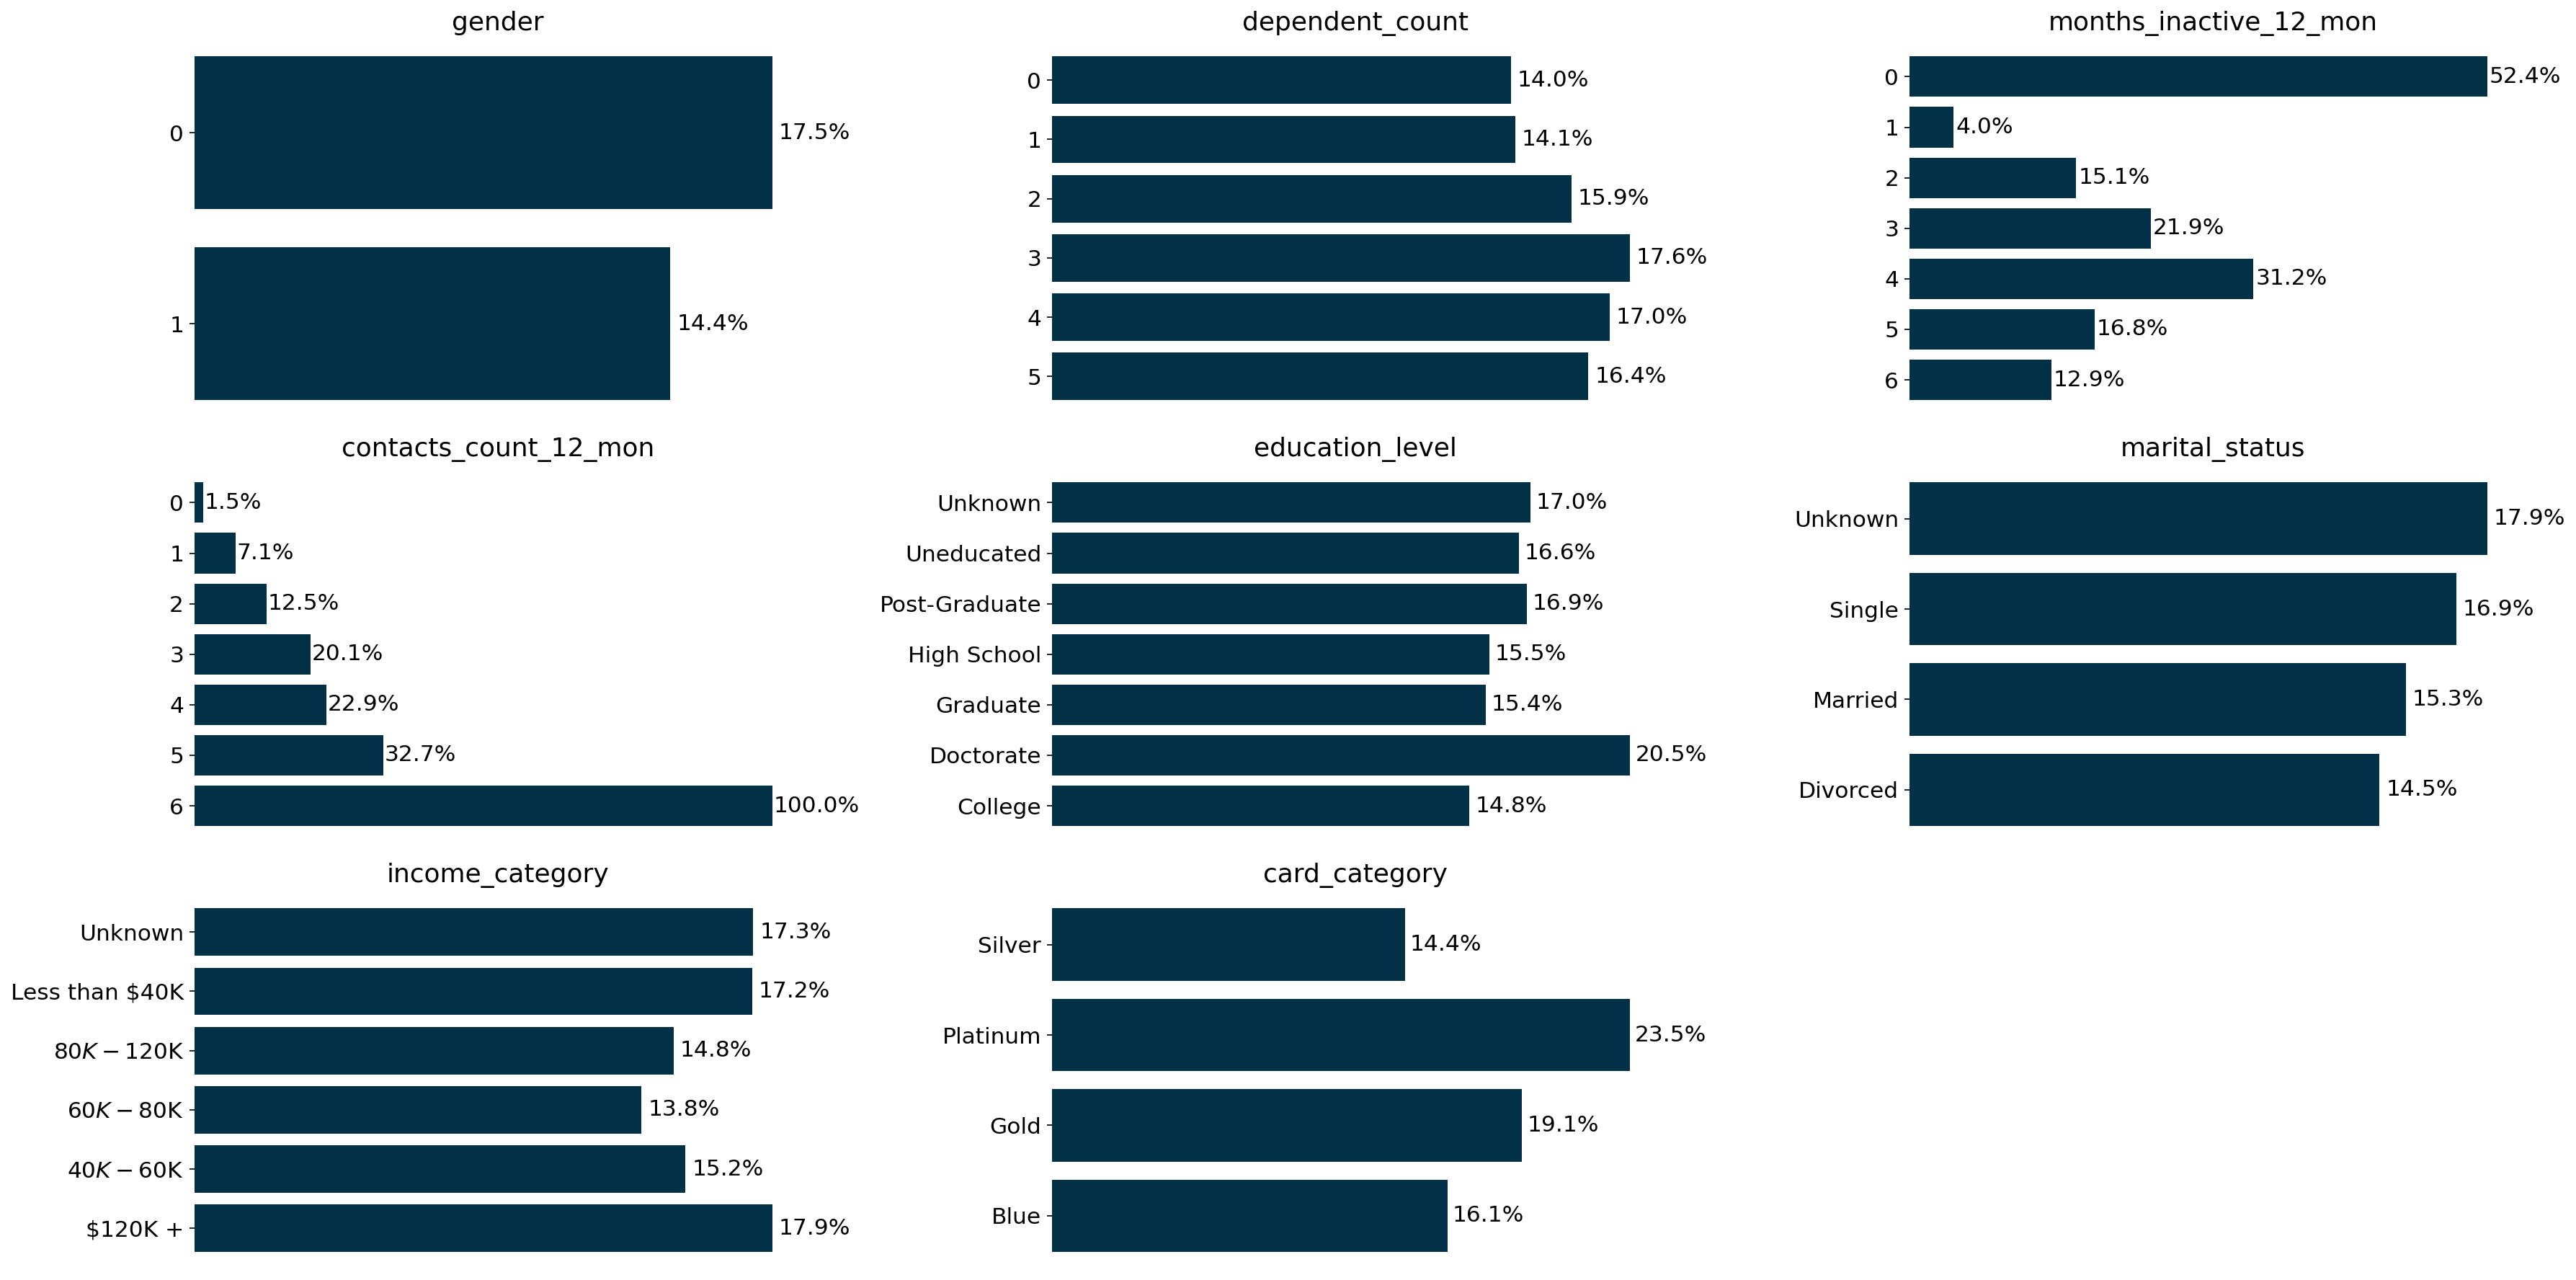

In [32]:
analysis_plots(data=train, features=barplot_features, barplot=True, figsize=(24, 12), hue=target, text_y=0.2)

Insights:
- The churn rate consistently increases monotonically as the number of contacts with the bank rises. Especially, all customers who made six contacts churned.
- In marital_status, the unknown category presents the highest churn rate. For education_level and income_category, it presents the second highest churn rates. Thus, it is a good practice to leave it as another category of these variables in the preprocessing step, once it helps discriminating between churners and non-churners.
- Although card_category is highly imbalanced towards blue type, it is possible to see that the churn rate varies across the categories. Particularly, Platinum presents the highest churn rate. Even having a very low number of observations, as I am focusing on the predictive power, building robust models such as LightGBM, I will leave this variable and assess its feature importance or apply a feature selection method to keep it or remove it further.
- The churn rate is higher for women.
- Surprisingly, customers who were never inactive in the last 12 months present the highest churn rate.
- Customers with doctorate educational level present the highest churn rate among the other levels.


# EDA conclusions

<b>Main insights:</b>
- The bank must be alert to the distribution of the average utilization ratio. Being right-skewed means that most customers have a low utilization of the service. Particularly, about 25% of them present zero utilization ratio. Therefore, the company must plan strategies to increase utilization and, consequently, revenue.
- 90% of the customers were inactive from 1 to 3 months in the last 12 months. The bank must plan strategies not only to increase the utilization ratio, but also to avoid customer inactivity.
- 75% of the customers contacted the bank at least 2 times in the last 12 months. The bank must pay attention to this and discover the reasons why customers are calling. Are they dissatisfied with the credit card service? If so, what specifically is causing their dissatisfaction?
-  Customer age and months on book are strongly positively correlated. The older a customer is, the more time he spends consuming the bank's credit card services and vice-versa. Thus, the company must focus its efforts on retaining the old loyal customers and increase the tenure of younger ones.
- Credit limit and average utilization ratio present an exponential decreasing relationship! This indicates that, as credit limit increases, the average utilization ratio decreases at an exponential rate. Thus, customers with higher credit limits use their credit cards less.
- Customers who churn tend to have lower credit limits, revolving balances, transaction amounts, transaction counts, changes in transaction counts, and average utilization ratios (actually, many of them present a zero utilization ratio). This makes total sense because when a client is about to discontinue the service, he will make fewer transactions, resulting in lower values of these attributes.
- The churn rate consistently increases monotonically as the number of contacts with the bank rises. Especially, all customers who made six contacts churned. Also, customers with doctorate educational level present the highest churn rate among the other levels.